In [4]:
# Testing out raw h5 data of Event 11707158 from https://dasway.ess.washington.edu/gci/events/2023-06-10/index.html
import h5py
import matplotlib.pyplot as plt
import os
import numpy as np
from denodas_model import unet
import torch
import torch.nn as nn
print(torch.cuda.device_count())

1


In [5]:
file_path = os.path.join("raw_data", "KKFLS.h5")

# Load the data
f = h5py.File(file_path, 'r')

# Get dimensions of data
data = f['Acquisition/Raw[0]/RawData'][:] # numpy array
data_time = f['Acquisition/Raw[0]/RawDataTime'][:]
data_sample_count = f['Acquisition/Raw[0]/RawDataSampleCount'][:]

print(f"Data shape: {data.shape}")
print(f"DataTime shape: {data_time.shape}")
print(f"DataSampleCount shape: {data_sample_count.shape}")

Data shape: (3000, 8531)
DataTime shape: (3000,)
DataSampleCount shape: (3000,)


In [6]:
# convert epoch time to datetime
# data_time = np.array([np.datetime64(int(x), 's') for x in data_time])
# convert epoch time to seconds
data_time = np.array([(x - data_time[0]).astype('timedelta64[s]').astype(int) for x in data_time])

In [7]:
# Test plotting
data2 = data[:1000,:1000]
print(data2.shape)

print("Minimum value:", np.min(data2)) 
print("Maximum value:", np.max(data2)) 
print("Mean value:", np.mean(data2)) 
print("Unique values:", np.unique(data2))

(1000, 1000)
Minimum value: -136.17287
Maximum value: 130.44748
Mean value: 0.47792816
Unique values: [-136.17287  -109.623375 -109.14452  ...  119.6782    122.22488
  130.44748 ]


In [8]:
sampling_rate = 50  # 50 Hz
time_vector = np.arange(0, data.shape[0] / sampling_rate, 1 / sampling_rate)
print(time_vector)

[0.000e+00 2.000e-02 4.000e-02 ... 5.994e+01 5.996e+01 5.998e+01]


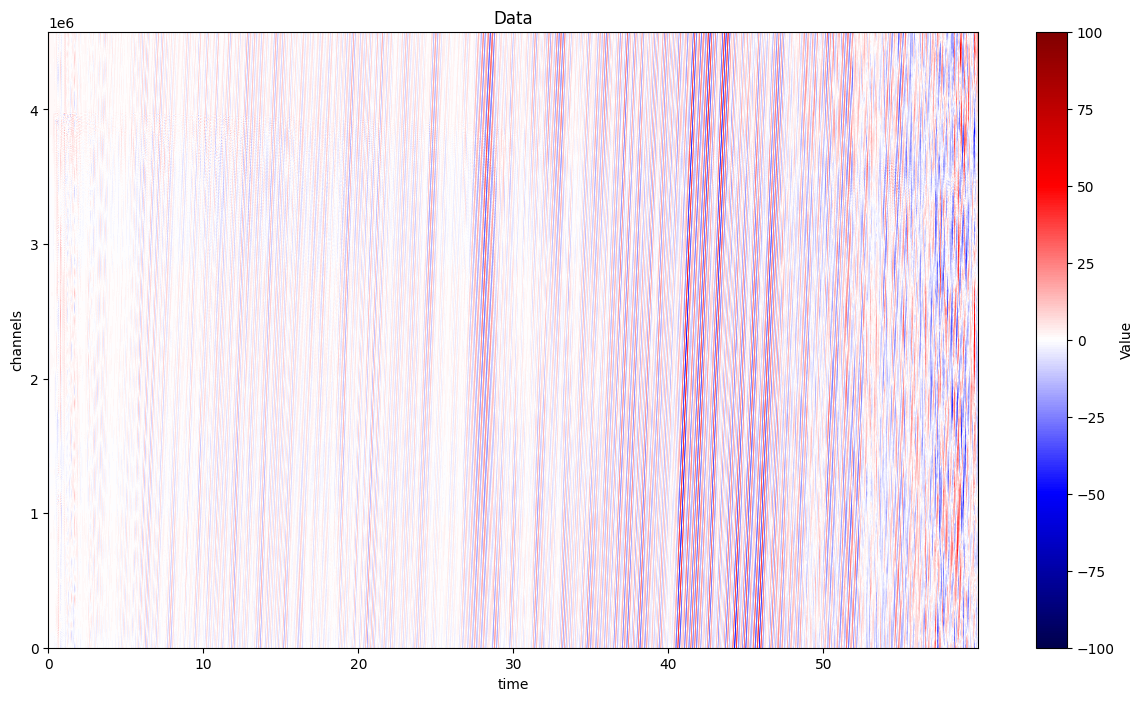

In [9]:
plt.figure(figsize=(15, 8)) # Adjust the figure size as needed 
# cap the values to 1e-3
# first dimension is time for 3000 samples and 200 Hz data
# second dimension is the number of channels

plt.imshow(data, aspect='auto', cmap='seismic',vmin=-1e2, vmax=1e2,extent=[0, time_vector[-1], 0, data_sample_count[-1]]) 
plt.colorbar(label='Value') # Add a colorbar for reference 
plt.title("Data") 
plt.xlabel("time")
plt.ylabel("channels")
plt.show()

In [10]:
from scipy.signal import butter, filtfilt

def highpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y = filtfilt(b, a, data, axis=0)
    return y

# Apply high-pass filter to the data
cutoff_frequency = 1  # 1 Hz
filtered_data = highpass_filter(data, cutoff_frequency, sampling_rate)

print(filtered_data)

[[ 2.21235851e-01  1.86994525e-01  1.47347660e-02 ... -1.61232029e+00
  -2.08476145e+00 -3.70246863e+00]
 [ 5.82771094e-01  1.36197085e+00  7.48496598e-01 ... -4.32654356e+00
  -9.44006855e+00 -5.25403512e+00]
 [ 7.11128790e-01  2.05949034e+00  1.17193787e+00 ... -1.28198144e+00
  -1.38578898e+01 -9.62941468e-01]
 ...
 [-1.39126398e+00 -8.31597713e-01  2.15616599e-01 ... -6.74506193e+00
  -7.07400194e+00 -2.58405234e+01]
 [-1.06397563e+00 -6.99012276e-01  6.75502537e-02 ... -2.95315090e+00
  -5.12248481e+00 -1.38436325e+01]
 [-7.08676405e-01 -5.06429672e-01  1.97107068e-01 ... -1.77046375e+00
  -5.03400939e+00 -2.70321906e+00]]


Text(0, 0.5, 'Channels')

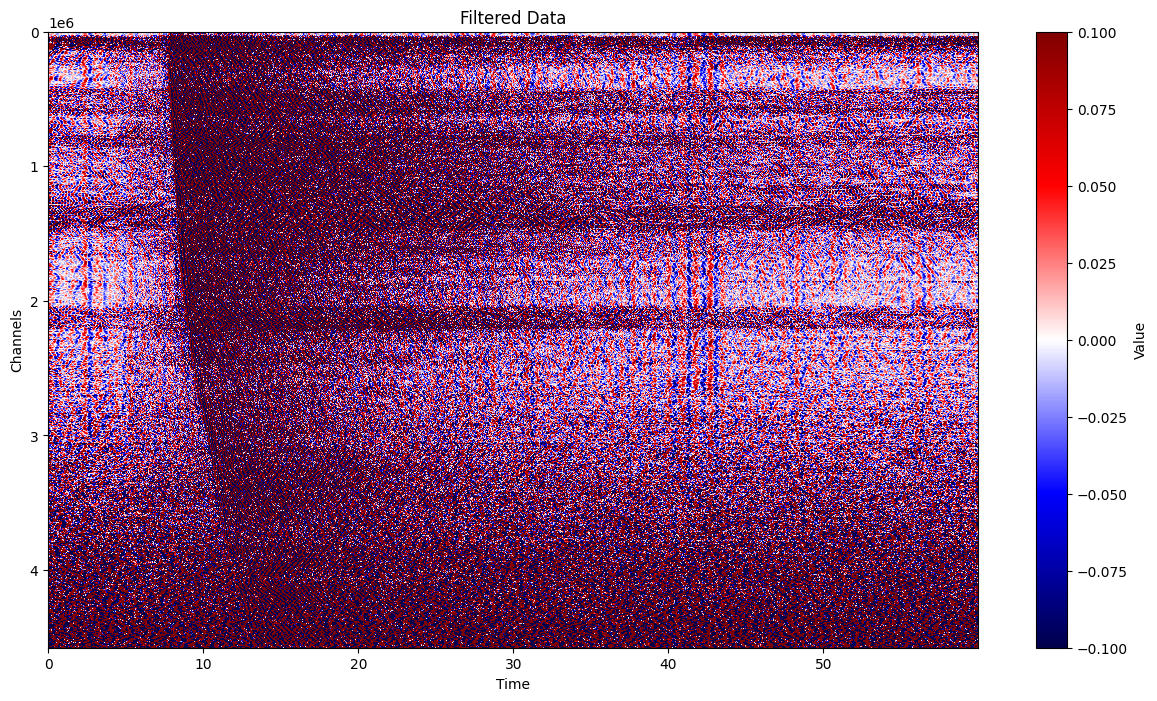

In [11]:
# plot the filtered data
plt.figure(figsize=(15, 8))
plt.imshow(filtered_data.T, aspect='auto', cmap='seismic', vmin=-1e-1, vmax=1e-1, extent=[0, time_vector[-1],  data_sample_count[-1],0])
plt.colorbar(label='Value')
plt.title("Filtered Data")
plt.xlabel("Time")
plt.ylabel("Channels")

In [12]:
# Function to process and plot data from h5 files
def process_and_plot_h5_files(h5_files, cutoff_frequency, sampling_rate, plot_folder='plots'):
    for file in h5_files:
        # Load the data
        f = h5py.File(file, 'r')
        data = f['Acquisition/Raw[0]/RawData'][:]  # numpy array
        data_time = f['Acquisition/Raw[0]/RawDataTime'][:]
        data_sample_count = f['Acquisition/Raw[0]/RawDataSampleCount'][:]

        # Convert epoch time to seconds
        data_time = np.array([(x - data_time[0]).astype('timedelta64[s]').astype(int) for x in data_time])

        # Apply high-pass filter to the data
        filtered_data = highpass_filter(data, cutoff_frequency, sampling_rate)

        # Create time vector for plotting
        time_vector = np.arange(0, data.shape[0] / sampling_rate, 1 / sampling_rate)

        # Save the filtered data as a numpy array
        filtered_data_file_path = os.path.join("test_data", f"{os.path.basename(file).split('.')[0]}.npy")
        np.save(filtered_data_file_path, filtered_data)

        # Plot the filtered data
        plt.figure(figsize=(15, 8))
        plt.imshow(filtered_data.T, aspect='auto', cmap='seismic', vmin=-1e-1, vmax=1e-1, extent=[0, time_vector[-1], data_sample_count[-1], 0])
        plt.colorbar(label='Value')
        plt.title(f"Filtered Data from {os.path.basename(file)}")
        plt.xlabel("Time")
        plt.ylabel("Channels")

        # Save the plot as an image
        plot_filename = os.path.join(plot_folder, f"{os.path.basename(file).split('.')[0]}.png")
        plt.savefig(plot_filename)
        plt.close()

In [13]:
raw_data_folder = "raw_data"
h5_files = [os.path.join(raw_data_folder, file) for file in os.listdir(raw_data_folder) if file.endswith('.h5')]
# Process and plot all h5 files
process_and_plot_h5_files(h5_files, cutoff_frequency, sampling_rate)

In [14]:
# model_1 = unet(1, 16, 1024, factors=(5, 3, 2, 2), use_att=False)
input_channels = 1         # Single-channel input
base_filters = 16          # Base number of filters
max_filters = 1024         # Maximum number of filters
downsampling_factors = (5, 3, 2, 2)  # Resampling factors for downsampling
kernel_size = (3, 3)       # Convolution kernel size
padding = (1, 1)           # Padding
use_attention = False      # Toggle attention mechanism

# Instantiate the U-Net model
model_1 = unet(
    ch_in=input_channels,
    ch0=base_filters,
    ch_max=max_filters,
    factors=downsampling_factors,
    kernel=kernel_size,
    pad=padding,
    use_att=use_attention
)
model_1 = nn.DataParallel(model_1, device_ids=[0])

""" Load the pretrained weights """
model_1.load_state_dict(torch.load(os.path.join('ml_models', 'denoiser_weights_LR08_MASK05_raw2raw_old.pt')))  # raw2raw 
model_1.eval()

DataParallel(
  (module): unet(
    (relu): ReLU()
    (layer): ModuleList(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): MaxBlurPool2d()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): MaxBlurPool2d()
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): MaxBlurPool2d()
      (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): Dropout(p=0.2, inplace=False)
      (12): MaxBlurPool2d()
      (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1

In [15]:
# # Put the data into a tensor
# test_data = np.load('test_data/KKFLS.npy') # shape: (3000, 8531)
# X = test_data[:,:].astype(np.float32)
# X = torch.from_numpy(X).to(devc) # ??

# # Denoise with the unet model
# with torch.no_grad():
#     oneDenoise_1 = model_1(X)  # Apply the model to input `X` for the first denoising
#     mulDenoise_1 = model_1(oneDenoise_1)  # Apply the model to the output again (second pass)
#     mulDenoise_1 = model_1(mulDenoise_1)  # Third pass
#     mulDenoise_1 = model_1(mulDenoise_1)  # Fourth pass